<a href="https://colab.research.google.com/github/olaf-ys/NLP-News-Topic-Identification/blob/main/ba820_project_AG_news_Yuanshan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import csv
import pandas as pd
import datetime
import numpy as np

# NLP
import re
import spacy

import gensim
from gensim import corpora, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklean
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN
from keras.callbacks import EarlyStopping
from keras import backend as K

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load, clean, and sample the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# List to hold formatted data
data = []

# Temporary list to hold fields that span multiple lines
current_fields = []

# Open the file and read line by line
with open('/content/drive/MyDrive/newsSpace.txt', 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Check if the line ends with a backslash indicating continuation
        if line.endswith('\\\n'):
            # Add the current line's content (except for the backslash and newline) to the current fields
            current_fields.append(line[:-2])
        else:
            # This line does not end with a backslash, so it is the end of the current entry
            # Combine any previously accumulated fields with the current line
            current_fields.append(line)
            full_entry = ''.join(current_fields)

            # Split the full entry into fields using the tab delimiter
            fields = full_entry.rstrip('\n').split('\t')

            # Ensure that each line has the correct number of fields
            if len(fields) == 9:
                data.append(fields)

            # Reset the current fields list for the next entry
            current_fields = []

# Convert the formatted data list to a DataFrame
df = pd.DataFrame(data, columns=['source', 'url', 'title', 'image', 'category', 'description', 'rank', 'pubdate', 'video'])

df.head()

,source,url,title,image,category,description,rank,pubdate,video
0,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Pullback Reflects Tech Blowout (Reuters),none,Business,"Reuters - Wall Street's long-playing drama,""Wa...",5,0000-00-00 00:00:00,\N
1,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Bears Claw Back Into the Black (Reuters),none,Business,"Reuters - Short-sellers, Wall Street's dwindli...",5,0000-00-00 00:00:00,\N
2,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Carlyle Looks Toward Commercial Aerospace (Reu...,none,Business,Reuters - Private investment firm Carlyle Grou...,5,0000-00-00 00:00:00,\N
3,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Oil and Economy Cloud Stocks' Outlook (Reuters),none,Business,Reuters - Soaring crude prices plus worriesabo...,5,0000-00-00 00:00:00,\N
4,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Iraq Halts Oil Exports from Main Southern Pipe...,none,Business,Reuters - Authorities have halted oil exportfl...,5,0000-00-00 00:00:00,\N


sample 5000 data points from 'Business', 'Entertainment', 'Sports', 'Sci/Tech' and merge title and description

In [4]:
sampled_category = ['Business', 'Entertainment', 'Sports', 'Sci/Tech']

lst = []

for i in sampled_category:
  lst.append(df[df['category'] == i].sample(n=5000, random_state=42))

data = pd.concat(lst)

data = data[['title', 'description', 'category']]

data['text'] = data['title'] + ' ' + data['description']

data = data[['text', 'category']].reset_index(drop=True)

data.head()

,text,category
0,Microsoft on Sale Mr. Softy lures PeopleSoft c...,Business
1,IBM &#39;to sell PC business&#39; IBM is repor...,Business
2,Gartner buys Meta Group Both Gartner and Meta ...,Business
3,Nikkei Dips for a 2nd Straight Session TOKYO ...,Business
4,GM Profit Falls on European Losses Here's how...,Business


# Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['category'], test_size=0.2, random_state=42)
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)

In [6]:
df_X_train.head()

,text
5894,Security Incident Prompts British Soul-Searchi...
3728,OPEC Head Sees Oil Demand Dropping (Reuters) R...
8958,MLB: Yankees Even Series with Twins The Major ...
7671,Japanese hostage probably killed in Iraq A bod...
5999,Oscar buzz focuses on screen bios A look at fi...


# Preprocessing

In [7]:
# Load the model, disabling unnecessary pipeline components (i.e. dependency parsing and named entity recognition)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_text(text):
    # Initialize an empty list to store cleaned texts
    cleaned_text = []

    # Clean each text
    for doc in text:
        doc = doc.lower() # Convert to lowercase
        doc = re.sub(r'[^a-z\s]', ' ', doc) # Remove special characters and digits
        doc = re.sub(r'\s+', ' ', doc).strip() # Remove extra white spaces
        cleaned_text.append(doc)


    preprocessed_text = []

    # Use nlp.pipe for batch processing of cleaned texts
    for doc in nlp.pipe(cleaned_text, batch_size=50): # use batch training to parallel computation
        # For each doc, extract lemmas of non-stop words
        lemmatized_text = [token.lemma_ for token in doc if not token.is_stop]
        preprocessed_text.append(lemmatized_text)

    return preprocessed_text

In [8]:
df_X_train['preprocessed_text'] = preprocess_text(df_X_train['text'].tolist())
df_X_test['preprocessed_text'] = preprocess_text(df_X_test['text'].tolist())
df_X_train[['text', 'preprocessed_text']].head()

,text,preprocessed_text
5894,Security Incident Prompts British Soul-Searchi...,"[security, incident, prompt, british, soul, se..."
3728,OPEC Head Sees Oil Demand Dropping (Reuters) R...,"[opec, head, see, oil, demand, drop, reuters, ..."
8958,MLB: Yankees Even Series with Twins The Major ...,"[mlb, yankee, series, twin, major, league, bas..."
7671,Japanese hostage probably killed in Iraq A bod...,"[japanese, hostage, probably, kill, iraq, body..."
5999,Oscar buzz focuses on screen bios A look at fi...,"[oscar, buzz, focus, screen, bio, look, film, ..."


# Determine threshold for minimum word frequency

In [9]:
tokens = df_X_train['preprocessed_text'].explode()

# tokens and their frequencies
token_frequency = tokens.value_counts()

token_frequency.describe()

count    34626.000000
mean        16.996419
std        156.840771
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      11443.000000
Name: preprocessed_text, dtype: float64

- The training data contains a total of 34626 unique words.
- The median frequency of word occurrences is 2, meaning half of the words appear no more than twice.
- The average frequency of word occurrences is about 17, but this figure is likely skewed by a few extremely high-frequency words such as `com`, `http`, `s`, `p`, `img`, etc.
- The most common word appears 11443 times, while the least common words appear only once.

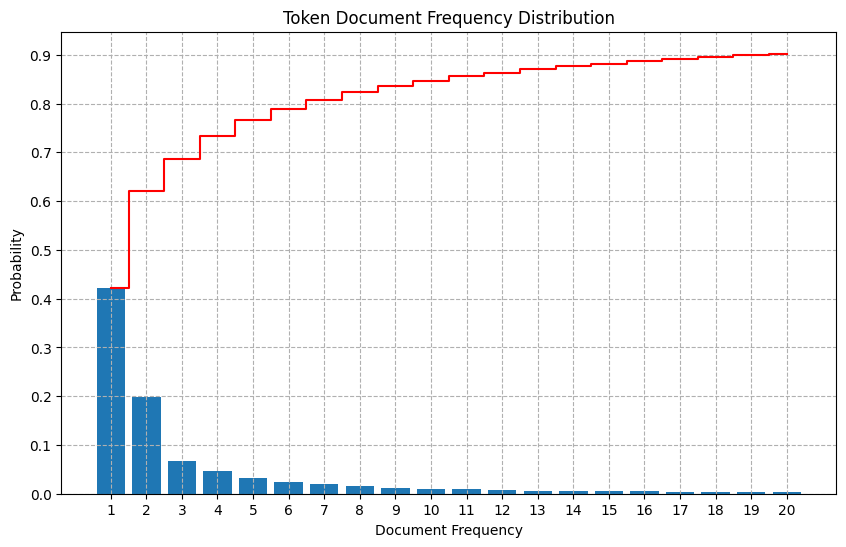

In [10]:
tokens = df_X_train['preprocessed_text'].explode()

# tokens and their frequencies
token_frequency = tokens.value_counts()

# frequencies and their times of being observed
frequency_obs = token_frequency.value_counts()

# total obersvations = number of total tokens
total_obs = token_frequency.count()

# frequencies and their prob of being observed
frequency_probability = (frequency_obs/total_obs)[0:20]

cumulative_percentage = frequency_probability.cumsum()

# bar plot
plt.figure(figsize=(10, 6))
plt.bar(frequency_probability.index, frequency_probability.values)
plt.step(frequency_probability.index, cumulative_percentage, where = 'mid', color = 'red')
plt.title('Token Document Frequency Distribution')
plt.xlabel('Document Frequency')
plt.ylabel('Probability')
plt.xticks(range(1, 21))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(linestyle='--')

plt.show()

- more than 40% of tokens appear no more than once
- more than 60% of tokens appear no more than twice

Therefore, the proper range of thresholds for min_count/min_df can be 3 or more

In [ ]:
thres = 3

# Modeling

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

def evaluate_model(X_train, X_test):
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  print(classification_report(y_test, y_pred))

### Bag of Words

In [ ]:
df_X_train['preprocessed_text_str'] = df_X_train['preprocessed_text'].apply(lambda x: ' '.join(x))
df_X_test['preprocessed_text_str'] = df_X_test['preprocessed_text'].apply(lambda x: ' '.join(x))

# vectorize X_train and X_test seperately
cv = CountVectorizer(min_df= thres)
X_train = cv.fit_transform(df_X_train['preprocessed_text_str'])
X_test = cv.transform(df_X_test['preprocessed_text_str'])

evaluate_model(X_train, X_test)

               precision    recall  f1-score   support

     Business       0.70      0.83      0.76       995
Entertainment       0.79      0.65      0.71      1024
     Sci/Tech       0.81      0.70      0.75       977
       Sports       0.82      0.93      0.87      1004

     accuracy                           0.78      4000
    macro avg       0.78      0.78      0.77      4000
 weighted avg       0.78      0.78      0.77      4000



### TF-IDF

In [ ]:
# vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = thres)
tfidf_train = tfidf.fit_transform(df_X_train['preprocessed_text_str'])
tfidf_test = tfidf.transform(df_X_test['preprocessed_text_str'])

evaluate_model(tfidf_train, tfidf_test)

               precision    recall  f1-score   support

     Business       0.73      0.83      0.77       995
Entertainment       0.77      0.66      0.71      1024
     Sci/Tech       0.80      0.71      0.75       977
       Sports       0.82      0.92      0.87      1004

     accuracy                           0.78      4000
    macro avg       0.78      0.78      0.78      4000
 weighted avg       0.78      0.78      0.78      4000



### Word2Vec

In [ ]:
# train a Word2Vec model
w2v = Word2Vec(sentences=df_X_train['preprocessed_text'], vector_size=100, window=2, min_count=thres, workers=2)

#### Average

In [ ]:
# get average word embedding
def avg(model, document):

    # Retrieve vectors for words in the vocabulary from the model
    vectors = [model.wv[word] for word in document if word in model.wv.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train = np.array([avg(w2v, doc) for doc in df_X_train['preprocessed_text']])
X_test = np.array([avg(w2v, doc) for doc in df_X_test['preprocessed_text']])

evaluate_model(X_train, X_test)

               precision    recall  f1-score   support

     Business       0.74      0.74      0.74       995
Entertainment       0.64      0.63      0.63      1024
     Sci/Tech       0.70      0.68      0.69       977
       Sports       0.81      0.85      0.83      1004

     accuracy                           0.72      4000
    macro avg       0.72      0.72      0.72      4000
 weighted avg       0.72      0.72      0.72      4000



#### IDF weighted average

In [ ]:
# Create a vocabulary and word vector mapping
word_vector_dict = {word: w2v.wv[word] for word in w2v.wv.index_to_key if word in tfidf.vocabulary_}

def idf_weighted_average(model, document):
    valid_words = [word for word in document if word in word_vector_dict]
    if not valid_words:
        return np.zeros(model.vector_size)

    weights = np.array([tfidf.idf_[tfidf.vocabulary_[word]] for word in valid_words])
    vectors = np.array([word_vector_dict[word] for word in valid_words])

    weighted_average = np.dot(weights, vectors) / weights.sum() if weights.size > 0 else np.zeros(model.vector_size)

    return weighted_average

# Apply the weighted average word vector
X_train = np.array([idf_weighted_average(w2v, doc) for doc in df_X_train['preprocessed_text']])
X_test = np.array([idf_weighted_average(w2v, doc) for doc in df_X_test['preprocessed_text']])

evaluate_model(X_train, X_test)

               precision    recall  f1-score   support

     Business       0.75      0.73      0.74       995
Entertainment       0.65      0.64      0.65      1024
     Sci/Tech       0.69      0.69      0.69       977
       Sports       0.83      0.87      0.85      1004

     accuracy                           0.73      4000
    macro avg       0.73      0.73      0.73      4000
 weighted avg       0.73      0.73      0.73      4000



#### TF-IDF weighted average

In [ ]:
# Create a vocabulary and word vector mapping
word2vec_vocab = w2v.wv.index_to_key
word_vector_dict = {word: w2v.wv[word] for word in word2vec_vocab if word in tfidf.vocabulary_}

feature_names = tfidf.get_feature_names_out()

def tfidf_weighted_avg(document, doc_index, tfidf_matrix):
    # Only consider words in both Word2Vec and TF-IDF vocabularies
    valid_words = [word for word in document if word in word_vector_dict]

    # initialize weighted vectors
    weighted_vector = np.zeros(w2v.vector_size)

    if not valid_words:
        return weighted_vector

    # get the tfidf row of the current document
    doc_tfidf = tfidf_matrix[doc_index].tocoo()

    # create a word and tfidf weight mapping
    word_to_tfidf = {feature_names[i]: value for i, value in zip(doc_tfidf.col, doc_tfidf.data)}

    # calculate tf-idf weighted avg
    total_weight = 0.0
    for word in valid_words:
        if word in word_to_tfidf:
            weight = word_to_tfidf[word]
            weighted_vector += weight * word_vector_dict[word]
            total_weight += weight

    if total_weight > 0:
        weighted_vector /= total_weight

    return weighted_vector

X_train = np.array([tfidf_weighted_avg(doc, i, tfidf_train) for i, doc in enumerate(df_X_train['preprocessed_text'])])
X_test = np.array([tfidf_weighted_avg(doc, i, tfidf_test) for i, doc in enumerate(df_X_test['preprocessed_text'])])

evaluate_model(X_train, X_test)

               precision    recall  f1-score   support

     Business       0.74      0.71      0.73       995
Entertainment       0.64      0.65      0.64      1024
     Sci/Tech       0.70      0.68      0.69       977
       Sports       0.81      0.86      0.84      1004

     accuracy                           0.72      4000
    macro avg       0.72      0.72      0.72      4000
 weighted avg       0.72      0.72      0.72      4000



### GloVe (pre-trained)

In [ ]:
# load api
import gensim.downloader as api

print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [ ]:
# load pretrained model
glove = api.load("glove-wiki-gigaword-100")

#### Average

In [ ]:
# get average word embedding
def avg(model, document):

    # Retrieve vectors for words in the vocabulary from the model
    vectors = [model[word] for word in document if word in model.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train = np.array([avg(glove, doc) for doc in df_X_train['preprocessed_text']])
X_test = np.array([avg(glove, doc) for doc in df_X_test['preprocessed_text']])

evaluate_model(X_train, X_test)

               precision    recall  f1-score   support

     Business       0.80      0.78      0.79       995
Entertainment       0.76      0.73      0.74      1024
     Sci/Tech       0.75      0.77      0.76       977
       Sports       0.89      0.93      0.91      1004

     accuracy                           0.80      4000
    macro avg       0.80      0.80      0.80      4000
 weighted avg       0.80      0.80      0.80      4000



## Deep Learning

### LSTM (Transfer Learning with GloVe)

1. convert each document into vector sequence

In [ ]:
# define a function to convert each document in data into vector sequence
def doc_to_vector_sequence(doc, model):
    vector_sequence = []
    for word in doc:
        if word in model.key_to_index:
            vector_sequence.append(model[word])
        else:
            # use zeros if not in the vocabulary
            vector_sequence.append(np.zeros(model.vector_size))
    return np.array(vector_sequence)

# apply function
X_train_sequence = [doc_to_vector_sequence(doc, glove) for doc in df_X_train['preprocessed_text']]
X_test_sequence = [doc_to_vector_sequence(doc, glove) for doc in df_X_test['preprocessed_text']]

# verify the result
print(X_train_sequence[0].shape)
X_train_sequence[0]

(25, 100)


array([[-0.54812 , -0.59526 ,  0.51106 , ...,  0.044368,  0.35067 ,
         0.53382 ],
       [-0.065712, -0.72067 ,  0.031713, ...,  0.32525 , -0.094653,
        -0.48188 ],
       [-0.086022, -0.2014  ,  0.0733  , ...,  0.08761 , -0.41186 ,
         0.25028 ],
       ...,
       [-0.23321 ,  0.19875 , -0.21014 , ...,  0.75232 ,  1.3898  ,
         0.4525  ],
       [-0.26094 ,  0.16636 , -0.19749 , ...,  0.16511 ,  0.60506 ,
        -0.43092 ],
       [ 0.24786 ,  0.44341 , -1.3163  , ...,  0.14317 ,  0.73518 ,
         0.58781 ]], dtype=float32)

2. padding

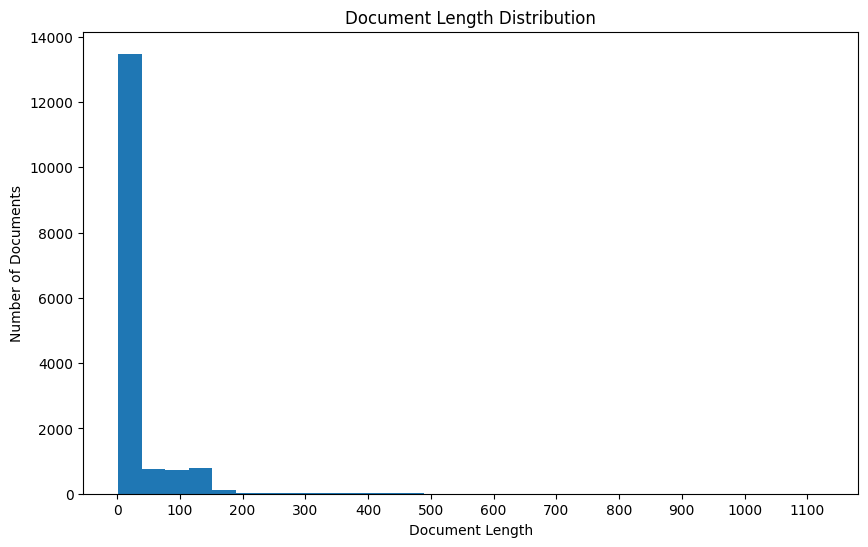

In [ ]:
# visualize document length distrib
doc_lengths = [len(doc) for doc in df_X_train['preprocessed_text']]

plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=30)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.xticks(range(0, max(doc_lengths) + 1, 100))
plt.show()

In [ ]:
np.quantile(doc_lengths, 0.99)

183.0

99% documents are shorter than 183. Therefore 180 can be set as the sequence length

In [ ]:
# pad the sequence
X_train_padded = pad_sequences(X_train_sequence, maxlen=180, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequence, maxlen=180, dtype='float32', padding='post', truncating='post')

# verify the result
print(X_train_padded[0].shape)
X_train_padded[0]

(180, 100)


array([[-0.54812 , -0.59526 ,  0.51106 , ...,  0.044368,  0.35067 ,
         0.53382 ],
       [-0.065712, -0.72067 ,  0.031713, ...,  0.32525 , -0.094653,
        -0.48188 ],
       [-0.086022, -0.2014  ,  0.0733  , ...,  0.08761 , -0.41186 ,
         0.25028 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

3. One-hot encode the target

In [ ]:
# one-hot encode target
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [ ]:
sequence_len = X_train_padded.shape[1]
embedding_dim = X_train_padded.shape[2]

# build model
model = Sequential()

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu', input_shape=(sequence_len, embedding_dim)))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using LSTM
model.add(LSTM(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 176, 80)           40080     
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 80)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                37120     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 77460 (302.58 KB)
Trainable params: 77460 (302.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train_padded, y_train_onehot, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 15s 66ms/step - loss: 1.0051 - accuracy: 0.5195 - val_loss: 0.7834 - val_accuracy: 0.6491
Epoch 2/10
200/200 [==============================] - 12s 62ms/step - loss: 0.7186 - accuracy: 0.6770 - val_loss: 0.7116 - val_accuracy: 0.6712
Epoch 3/10
200/200 [==============================] - 12s 62ms/step - loss: 0.5994 - accuracy: 0.7846 - val_loss: 0.5758 - val_accuracy: 0.8047
Epoch 4/10
200/200 [==============================] - 12s 61ms/step - loss: 0.5074 - accuracy: 0.8334 - val_loss: 0.5516 - val_accuracy: 0.8144
Epoch 5/10
200/200 [==============================] - 12s 61ms/step - loss: 0.4416 - accuracy: 0.8551 - val_loss: 0.6245 - val_accuracy: 0.8169
Epoch 6/10
200/200 [==============================] - 12s 62ms/step - loss: 0.4089 - accuracy: 0.8664 - val_loss: 0.5121 - val_accuracy: 0.8256
Epoch 7/10
200/200 [==============================] - 12s 61ms/step - loss: 0.3830 - accuracy: 0.8771 - val_loss: 0.5440 - val_accuracy:

In [ ]:
def evaluate_model(X_test):
  # predict
  prediction = model.predict(X_test)

  # convert the predictions to class indices
  y_pred = np.argmax(prediction, axis=1)

  # convert the true labels to class indices
  y_true = np.argmax(y_test_onehot, axis=1)

  # Retrieve category names
  cat_names = pd.get_dummies(y_train).columns.tolist()
  y_pred_label = [cat_names[i] for i in y_pred]
  y_test_label = [cat_names[i] for i in y_true]

  # evaluate
  print(classification_report(y_test_label, y_pred_label))

In [ ]:
evaluate_model(X_test_padded)

125/125 [==============================] - 2s 13ms/step
               precision    recall  f1-score   support

     Business       0.76      0.86      0.81       995
Entertainment       0.87      0.67      0.75      1024
     Sci/Tech       0.81      0.82      0.81       977
       Sports       0.88      0.97      0.92      1004

     accuracy                           0.83      4000
    macro avg       0.83      0.83      0.82      4000
 weighted avg       0.83      0.83      0.82      4000



### LSTM

In [ ]:
# Tokenize and vectorize text
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([df_X_train['preprocessed_text'], df_X_test['preprocessed_text']], axis=0))

# Determine vocab_size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the OOV token

# Convert to sequence
X_train_sequences = tokenizer.texts_to_sequences(df_X_train['preprocessed_text'])
X_test_sequences = tokenizer.texts_to_sequences(df_X_test['preprocessed_text'])

X_train_padded = pad_sequences(X_train_sequences, maxlen=sequence_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=sequence_len, padding='post', truncating='post')

# build model
model = Sequential()

# add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using LSTM
model.add(LSTM(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 100)          3924400   
                                                                 
 conv1d (Conv1D)             (None, 176, 80)           40080     
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 80)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                37120     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 4001860 (15.27 MB)
Trainable params: 4001860 (15.27 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train_padded, y_train_onehot, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 23s 107ms/step - loss: 1.1774 - accuracy: 0.4171 - val_loss: 0.8783 - val_accuracy: 0.6419
Epoch 2/10
200/200 [==============================] - 21s 104ms/step - loss: 0.6591 - accuracy: 0.7543 - val_loss: 0.6602 - val_accuracy: 0.7763
Epoch 3/10
200/200 [==============================] - 20s 102ms/step - loss: 0.4016 - accuracy: 0.8805 - val_loss: 0.6738 - val_accuracy: 0.7900
Epoch 4/10
200/200 [==============================] - 21s 106ms/step - loss: 0.2799 - accuracy: 0.9246 - val_loss: 0.7541 - val_accuracy: 0.7834
Epoch 5/10
200/200 [==============================] - 26s 128ms/step - loss: 0.2317 - accuracy: 0.9434 - val_loss: 0.7465 - val_accuracy: 0.7794
Epoch 6/10
200/200 [==============================] - 22s 108ms/step - loss: 0.1818 - accuracy: 0.9580 - val_loss: 0.7944 - val_accuracy: 0.7825
Epoch 7/10
200/200 [==============================] - 21s 103ms/step - loss: 0.1569 - accuracy: 0.9640 - val_loss: 0.9222 - val_ac

In [ ]:
evaluate_model(X_test_padded)

125/125 [==============================] - 2s 13ms/step
               precision    recall  f1-score   support

     Business       0.75      0.82      0.78       995
Entertainment       0.70      0.70      0.70      1024
     Sci/Tech       0.76      0.79      0.78       977
       Sports       0.92      0.81      0.86      1004

     accuracy                           0.78      4000
    macro avg       0.78      0.78      0.78      4000
 weighted avg       0.78      0.78      0.78      4000



### Simple RNN

In [ ]:
# Tokenize and vectorize text
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([df_X_train['preprocessed_text'], df_X_test['preprocessed_text']], axis=0))

# Determine vocab_size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the OOV token

# Convert to sequence
X_train_sequences = tokenizer.texts_to_sequences(df_X_train['preprocessed_text'])
X_test_sequences = tokenizer.texts_to_sequences(df_X_test['preprocessed_text'])

X_train_padded = pad_sequences(X_train_sequences, maxlen=sequence_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=sequence_len, padding='post', truncating='post')

# build model
model = Sequential()

# add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using SimpleRNN
model.add(SimpleRNN(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 100)          3924400   
                                                                 
 conv1d (Conv1D)             (None, 176, 80)           40080     
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 80)            0         
 D)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                9280      
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 3974020 (15.16 MB)
Trainable params: 3974020 (15.16 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train_padded, y_train_onehot, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 21s 100ms/step - loss: 0.8569 - accuracy: 0.6538 - val_loss: 0.7320 - val_accuracy: 0.7281
Epoch 2/10
200/200 [==============================] - 18s 90ms/step - loss: 0.2942 - accuracy: 0.9066 - val_loss: 0.6660 - val_accuracy: 0.7859
Epoch 3/10
200/200 [==============================] - 18s 91ms/step - loss: 0.0991 - accuracy: 0.9720 - val_loss: 0.8589 - val_accuracy: 0.7572
Epoch 4/10
200/200 [==============================] - 18s 90ms/step - loss: 0.0344 - accuracy: 0.9916 - val_loss: 0.9482 - val_accuracy: 0.7784
Epoch 5/10
200/200 [==============================] - 18s 92ms/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 1.0225 - val_accuracy: 0.7725
Epoch 6/10
200/200 [==============================] - 18s 88ms/step - loss: 0.0317 - accuracy: 0.9904 - val_loss: 1.0796 - val_accuracy: 0.7559
Epoch 7/10
200/200 [==============================] - 18s 90ms/step - loss: 0.0423 - accuracy: 0.9889 - val_loss: 1.2118 - val_accuracy

In [ ]:
evaluate_model(X_test_padded)

125/125 [==============================] - 1s 10ms/step
               precision    recall  f1-score   support

     Business       0.75      0.77      0.76       995
Entertainment       0.71      0.70      0.71      1024
     Sci/Tech       0.80      0.68      0.73       977
       Sports       0.80      0.90      0.85      1004

     accuracy                           0.76      4000
    macro avg       0.77      0.76      0.76      4000
 weighted avg       0.76      0.76      0.76      4000

